# Keras tutorial
## Here, we use the model subclassing API to i) conjoin two pretrained models, ii) freeze the parameters of the second model, and then iii) the train the lower-level, first model by backpropagating through the second. 
## This is a toy example to show how this can be implented in keras, as opposed to learning some useful task. 
### We also add the capability to use custom loss functions to pretrain each model, and the combined model. 


### Specifically, we partially train an autoencoder, and seperately partially train a classifier. We then conjoin the two models together (autoencoder -> classifier), freezing the weights of the classifer. The weights of the autoencoder are then updated to prepare inputs in a way that maximises classification accuracy when processed by the partially trained classifier. 

### Import dependencies

In [1]:
import numpy as np
import keras
import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras import layers

print(tf. __version__) 
print(keras.__version__)

2.9.0
2.9.0


### Load in MNIST data

In [2]:
# Model / data parameters
num_classes = 10

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype(np.float32)
x_train_1 = x_train[1:200,:,:]
x_train_2 = x_train[200:1200,:,:]
x_train_combined = np.array(x_train[1200:2200,:,:])

x_val_1 = x_train[2200:2400,:,:]
x_val_2 = x_train[2400:2500,:,:]
x_val_combined = np.array(x_train[2500:2600,:,:])

x_test_1 = x_train[2600:2700,:,:]
x_test_2 =   x_train[2700:2800,:,:]
x_test_combined = np.array(x_train[2800:2900,:,:])

y_train = y_train.astype(np.float32)

y_train_1 = y_train[1:200]
y_train_2 = y_train[200:1200]
y_train_combined = np.array(y_train[1200:2200])

y_val_1 = y_train[2200:2400]
y_val_2 = y_train[2400:2500]
y_val_combined = np.array(y_train[2500:2600])

y_test_1 = y_train[2600:2700]
y_test_2 = y_train[2700:2800]
y_test_combined = np.array(y_train[2800:2900])


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


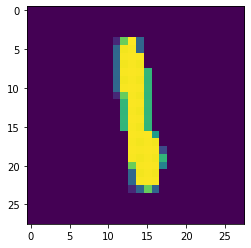

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# data is your array

array = np.squeeze(x_train_2[0,:,:])
print(np.squeeze(y_train_2[0,:]))

plt.imshow(array)

### Define the graph
net_1 is a convolutional autoencoder.  
net_2 is a classifier.  


In [4]:


net_input_1 = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(net_input_1)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
#x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
x = layers.Conv2D(1, 3, activation="relu",padding="SAME")(x)
x = layers.Flatten()(x)
x = layers.Dense(20)(x)
x = layers.Dense(49)(x)
x = layers.Reshape((7,7,1))(x)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)

net_output_1 = layers.Conv2D(1, 3, activation="relu",padding="SAME", name="net_1_out")(x)

net_input_2 = keras.Input(shape=(28, 28, 1), name="img")


x = layers.Conv2D(32, 3, activation="relu",padding="SAME", name="model_2_lay_1")(net_input_2)
x = layers.Conv2D(32, 3, activation="relu",padding="SAME")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, activation="relu",padding="SAME")(x)
x = layers.Conv2D(32, 3, activation="relu",padding="SAME")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(16, 3, activation="relu",padding="SAME")(x)
x = layers.Conv2D(32, 3, activation="relu",padding="SAME")(x)
x = layers.Conv2D(1, 3, activation="relu",padding="SAME")(x)
x = layers.Flatten()(x)
net_output_2= layers.Dense(num_classes,activation="softmax")(x)


### Set hyperparameters and loss functions

In [5]:
BATCH_SIZE = 5
EPOCHS = 30
NET_1_WEIGHTS = 'net_1_30.hd5'
NET_2_WEIGHTS = 'net_2_20.hd5' 

def loss_1(y_true, y_pred):
        squared_difference = tf.square(y_true - y_pred)
        return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`
    
def loss_2(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`
    
def loss_3(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

### Construct models
The combined_model is net_1 and net_2 chained together. 
The workflow is as follows, and is defiend in the fit function:  
i) Check if weights exist for net_1 and net_2. 
ii) If so, load them in. Otherwise, pretrain each network using their respective pretrain functions. 
iii) Conjoin both models, and freeze the weights of net_1.
iv) Train the combined model using the combined model training function. 

In [6]:
# use self when referring to something defined within the class.
# MyModel inherets object class - in python 3, there probably isn't a need to do this, but we keep it to illustrate potential functionality.

class MyModel(object):
    # initialise instance attributes in __init_ - these are manipulated by the functions in the class.
    # Keras model takes variable input_shape as an input, so we include this as an input. 
    def __init__(self,input_shape):
        # super below runs the __init__ of parent class (in this case, object).
        # we don't really need this, but it's kept to illustrate potential functionality.
        super(MyModel,self).__init__()
        # input_shape variable
        self.input_shape = input_shape
        # net_1 is the autoencoder
        self.net_1 = keras.Model(net_input_1, net_output_1, name="net_1")
        # net_2 is a CNN classifier appended to the pretrained net_1
        self.net_2 = keras.Model(net_input_2, net_output_2, name="net_2")
        net_2_out = self.net_2(self.net_1.output)
        # the combined network is the pretrained net_1 and net_2 chained together
        self.combined_net = keras.Model(self.net_1.input, net_2_out, name="combined_net")
        
    # we define a function that pretrains net_1, and saves the weights
    def pretrain_net_1(self, x, x_val, batch_size=BATCH_SIZE, epochs=100, optimizer='adam', save_dir='./'):
        print('...Pretraining net_1...')
        class CustomSaver(keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
                # we use self.model because we are inhereting the keras.callbacks.Callback class which uses the model attribute
                self.model.save("net_1_{}.hd5".format(epoch))  
        self.net_1.compile(optimizer=optimizer, loss=loss_1)
        #Log autoencoder module training progress
        from keras.callbacks import CSVLogger
        csv_logger = CSVLogger('pretrain_log_net_1.csv')
        saver = CustomSaver()

        # begin training
        self.net_1.fit(x, x, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[csv_logger,saver],validation_data=(x_val, x_val))
        self.net_1.save(save_dir + '/pretrain_net_1_model')
        print('Pretrained weights are saved to %s/pretrain_net_1_model' % save_dir)
                
    # we also define a function that pretrains net_2, and saves the weights
    def pretrain_net_2(self, x, y, x_val, y_val, batch_size=BATCH_SIZE, epochs=100, optimizer='adam', save_dir='./'):
        print('...Pretraining net_2...')
        class CustomSaver(keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
                # we use self.model because we are inhereting the keras.callbacks.Callback class which uses the model attribute
                self.model.save("net_2_{}.hd5".format(epoch))  
        self.net_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        #Log autoencoder module training progress
        from keras.callbacks import CSVLogger
        csv_logger = CSVLogger('pretrain_log_net_2.csv')
        saver = CustomSaver()

        # begin training
        self.net_2.fit(x, y, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[csv_logger,saver],validation_data=(x_val, y_val))
        self.net_2.save(save_dir + '/pretrain_net_2_model')
        print('Pretrained weights are saved to %s/pretrain_net_2_model' % save_dir)
    
    # this function trains the combined network                    
    def train_combined_net(self, x, y, x_val,y_val, batch_size=BATCH_SIZE, epochs=EPOCHS, optimizer='adam', save_dir='./'):
        print('...Training combined_net...')
        class CustomSaver(keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
                # we use self.model because we are inhereting the keras.callbacks.Callback class which uses the model attribute
                self.model.save("combined_net_{}.hd5".format(epoch))
        train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        self.combined_net.compile(optimizer=optimizer, loss='categorical_crossentropy')
        #Log autoencoder module training progress
        from keras.callbacks import CSVLogger
        csv_logger = CSVLogger('pretrain_log_combined.csv')
        saver = CustomSaver()
        # begin training
        #self.combined_net.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[csv_logger,saver],validation_data=(x_val, y_val))
        
        #####
        import time
        epochs = 30
        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the batches of the dataset.
            for batch_index in range((np.floor(x_train_combined.shape[0])/BATCH_SIZE).astype(int)):
                x_batch_train = x[batch_index * BATCH_SIZE:(batch_index + 1) * batch_size,:,:]
                y_batch_train = y[batch_index * BATCH_SIZE:(batch_index + 1) * batch_size]
                
                with tf.GradientTape() as tape:
                    logits = self.combined_net(x_batch_train, training=True)
                    loss_value = loss_3(y_batch_train, logits)
                grads = tape.gradient(loss_value, self.combined_net.trainable_weights)
                optimizer = keras.optimizers.Adam()
                optimizer.apply_gradients(zip(grads, self.combined_net.trainable_weights))
                y_batch_train = np.expand_dims(y_batch_train,axis=1)
                # Update training metric.
                #print(y_batch_train)
                #print(np.shape(logits))
                train_acc_metric.update_state(y_batch_train, logits)

            # Display metrics at the end of each epoch.
            train_acc = train_acc_metric.result()
            print("Training loss over epoch: %.4f" % (float(train_acc),))

            # Reset training metrics at the end of each epoch
            train_acc_metric.reset_states()
            
            combined_net_validation_outputs = self.combined_net(x_val)
            val_acc_metric.update_state(y_val, combined_net_validation_outputs)
            val_acc = val_acc_metric.result()
            print("Validation loss over epoch: %.4f" % (float(val_acc),))
            val_acc_metric.reset_states()

            
        #####
        self.combined_net.save(save_dir + '/train_combined_net_model')
        print('combined model weights are saved to %s/pretrain_combined_net_model' % save_dir)

        
    # in fit, we excute the workflow described in the section's header
    def fit(self, x_train_1, y_train_1, x_train_2, y_train_2, x_train_combined, y_train_combined, x_val_1, y_val_1, x_val_2, y_val_2, x_val_combined,y_val_combined, batch_size=BATCH_SIZE, net_1_weights=None,net_2_weights=None, save_dir='./'):
        if net_1_weights is None:
            print('...pretraining net_1:')
            self.pretrain_net_1(x=x_train_1,x_val=x_val_1, batch_size=BATCH_SIZE)
            
        elif net_1_weights is not None:
            print('LOADING net_1 WEIGHTS')
            self.net_1.load_weights(net_1_weights)
            print('net_1 weights loaded successfully.')
            
        if net_2_weights is None:
            print('...pretraining net_2:')
            self.pretrain_net_2(x_train_2, y_train_2,x_val=x_val_2, y_val=y_val_2, batch_size= BATCH_SIZE)
            
        elif net_2_weights is not None:
            print('LOADING net_2 WEIGHTS')
            self.net_2.load_weights(net_2_weights)
            print('net_2 weights loaded successfully.')
            
        self.net_2.trainable = False
        self.train_combined_net(x_train_combined, y_train_combined, x_val_combined, y_val_combined)


In [7]:
our_model = MyModel(input_shape = (28,28,1))
our_model.combined_net.summary()
our_model.fit(x_train_1 = x_train_1, y_train_1=y_train_1, x_train_2=x_train_2, y_train_2=y_train_2, x_train_combined=x_train_combined, y_train_combined=y_train_combined, x_val_1=x_val_1, y_val_1=y_val_1,x_val_2=x_val_2, y_val_2=y_val_2, x_val_combined=x_val_combined,y_val_combined=y_val_combined, batch_size=BATCH_SIZE,net_1_weights=NET_1_WEIGHTS, net_2_weights=NET_2_WEIGHTS, save_dir='./')

Model: "combined_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        2320      
                                                      

INFO:tensorflow:Assets written to: .//train_combined_net_model\assets


INFO:tensorflow:Assets written to: .//train_combined_net_model\assets


combined model weights are saved to .//pretrain_combined_net_model


In [8]:
score = our_model.combined_net.evaluate(x_test_combined, y_test_combined, verbose=0)
print("Test loss:", score)


Test loss: 2.3865113258361816
